# Multi-state Prediction

In [1]:
import sys
from pathlib import Path

# Add the parent directory of this script to sys.path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

# Now you can import modules from the parent directory
import torch
from helpers.simulation import *
from helpers.models import *
from helpers.eval import *
from settings import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

## Multi-state: Isotropic

In [2]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 6,
    "dropout": 0.05,
    "batch_size": 16,
    "loss_fn": mse_loss_coeff,
    "weight_decay": 0.01,
    "use_pos_embed": False,
    "use_segment_embed": True,
    "use_rotary": True
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model type
model = MultiStateModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
                    model_props['num_layers'], model_props['dropout'], output_dim=output_size, use_pos_embed=model_props['use_pos_embed'],
                    use_segment_embed=model_props['use_segment_embed'], use_rotary=model_props['use_rotary'])
print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Load pretrained model
model_path = '../results_final/multi_state_iso_250000_15_64_0.0001_0.01.pt'
checkpoint = torch.load(model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
disp_stats = checkpoint['norm_stats']
model.to(device)
model.eval()

Using device: cuda
Total params of MultiStateModel: 925026


MultiStateModel(
  (image_encoder): DeepResNetEmbedding(
    (initial_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (res_block1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res_block2): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3

In [3]:
import numpy as np

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame

image_props = ISOTROPIC_PROPS

#np.random.seed(1)

losses = []
for i in range(1):
    all_videos, og_displacements, og_labels = create_multi_state_dataset_w_features(N, T, image_props, binding=False)

    loss, sim = multi_state_eval_isotropic(all_videos, og_displacements, og_labels, disp_stats, model, model_props, image_props, device)

    losses.append(loss)

losses = np.array(losses)

print(f"Average loss: {losses.mean()}")
print(f"Std of loss: {losses.std()}")

Average loss across validation set: 0.00870335280337626
Average MAE of diffusion coefficients and angle simularity across validation set: [0.3953884  0.39517877]
Average L2-based similarity of diffusion tensors across validation set: 0.9834388494491577
--------------------------------------------------
Average loss: 0.00870335280337626
Std of loss: 0.0


In [ ]:
# Or load evaluation data from training (better to create test set like above)
data = np.load('../data/multi_state_norm_iso.npz')
all_videos = data['vids']
all_displacements = data['disp']
og_labels = data['labels']

In [ ]:
avg_loss, avg_sim = multi_state_eval_isotropic(all_videos, og_displacements, og_labels, disp_stats, model, model_props, image_props, device)

Average loss across validation set: 0.008571900827750849
Average MAE of diffusion coefficients and angle simularity across validation set: [0.39377207 0.39356822]
Average L2-based similarity of diffusion tensors across validation set: 0.9836567640304565
--------------------------------------------------


## Multi-state: Binding

In [13]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 6,
    "dropout": 0.05,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01,
    "use_pos_embed": False,
    "use_segment_embed": True,
    "use_rotary": True
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model type
model = MultiStateModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
                    model_props['num_layers'], model_props['dropout'], output_dim=output_size, use_pos_embed=model_props['use_pos_embed'],
                    use_segment_embed=model_props['use_segment_embed'], use_rotary=model_props['use_rotary'])
print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Load pretrained model
model_path = '../results_final/multi_state_binding_250000_20_64_0.0001_0.05.pt'
checkpoint = torch.load(model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
disp_stats = checkpoint['norm_stats']
model.to(device)
model.eval()

Using device: cuda
Total params of MultiStateModel: 925284


MultiStateModel(
  (image_encoder): DeepResNetEmbedding(
    (initial_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (res_block1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res_block2): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3

In [14]:
import numpy as np

# Image parameters
N = 5000 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame

image_props = BINDING_IMAGE_PROPS

losses = []
for i in range(1):
    all_videos, og_displacements, og_labels = create_multi_state_dataset_w_features(N, T, image_props, binding=True)

    loss, sim, angles = multi_state_eval(all_videos, og_displacements, og_labels, disp_stats, model, model_props, image_props, device)

    losses.append(loss)

losses = np.array(losses)

print(f"Average loss: {losses.mean()}")
print(f"Std of loss: {losses.std()}")

Creating a binding dataset
Average loss across validation set: 0.34619899644593527
Average MAE of diffusion coefficients and angle simularity across validation set: [0.2821045  0.22491312 0.94444263]
Average L2-based similarity of diffusion tensors across validation set: 0.9824496507644653
--------------------------------------------------


ValueError: not enough values to unpack (expected 3, got 2)

In [8]:
avg_loss, avg_sim = multi_state_eval(all_videos, og_displacements, og_labels, disp_stats, model, model_props, image_props, device)

Average loss across validation set: 0.3405375728371796
Average MAE of diffusion coefficients and angle simularity across validation set: [0.27928957 0.22768764 0.9454518 ]
Average L2-based similarity of diffusion tensors across validation set: 0.9823793172836304
--------------------------------------------------


In [7]:
play_video(all_videos[0])

vmin: -0.13230128586292267 vmax: 1.1192967891693115 mean: 0.15


## Changepoint Detection

In [5]:
all_videos = torch.Tensor(all_videos)
all_displacements = normalize_displacements(og_displacements, disp_stats)
all_displacements = torch.Tensor(all_displacements)

D_max_normalization = image_props['D_max_norm']
all_labels = og_labels / np.array([D_max_normalization, D_max_normalization, 1])
all_labels = torch.Tensor(all_labels)

# Create dataset and dataloader
dataset = VideoMotionDataset(all_videos, all_displacements, all_labels)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

plot_preds = []
plot_labels = []

with torch.no_grad():
    loss = []
    errors = []
    mse_sims = []
    
    for videos, displacements, labels in dataloader:
        videos = videos.to(device)
        labels = labels.to(device)
        
        if displacements.numel() != 0:
            displacements = displacements.to(device)
            val_predictions = model(videos, displacements)
        else:
            val_predictions = model(videos)

        val_loss = model_props['loss_fn'](val_predictions, labels)
        loss.append(val_loss.item()) # batch loss
        
        #angle_pred = 0.5 * torch.atan2(val_predictions[...,2], val_predictions[...,3])
        
        sims = mse_similarity(val_predictions, labels)

        mae = (val_predictions[...,:2] - labels[...,:-1]).abs().mean(axis=((0,1) if labels.dim()==3 else 0))

        #angle_sim = torch.abs(torch.cos(angle_pred - labels[...,-1])).mean().unsqueeze(-1)
        errors.append(torch.cat([
                mae.cpu() * D_max_normalization,
                #angle_sim.cpu()
            ], axis=0))
        mse_sims.append(sims.cpu())
        
        plot_preds.extend([p.cpu() for p in val_predictions])
        plot_labels.extend([l.cpu() for l in labels])
        
    # Compute average across all labels
    avg_loss = np.mean(loss)
    avg_error = np.mean(errors, axis=0)
    print(f"Average loss across validation set: {avg_loss}")
    print(f"Average MAE of diffusion coefficients and angle simularity across validation set: {avg_error}")
    print(f"Average L2-based similarity of diffusion tensors across validation set: {np.mean(mse_sims)}")

Average loss across validation set: 0.008465084896844093
Average MAE of diffusion coefficients and angle simularity across validation set: [0.3907904  0.39065826]
Average L2-based similarity of diffusion tensors across validation set: 0.9838590025901794


In [6]:
changepoints_pred = get_changepoints(np.array(plot_preds)[...,:2])
changepoints_label = get_changepoints(np.array(plot_labels)[...,:2])

@interact(i=IntSlider(value=0, min=0, max=len(plot_preds), step=1))
def plot_point_based(i):
    # Plot predictions and labels across frames
    fig, (ax1,ax2) = plt.subplots(2,1)

    pred_D1 = plot_preds[i][:,0] * D_max_normalization
    pred_D2 = plot_preds[i][:,1] * D_max_normalization
    label_D1 = plot_labels[i][:,0] * D_max_normalization
    label_D2 = plot_labels[i][:,1] * D_max_normalization

    ax1.plot(pred_D1, label='Prediction')
    ax1.plot(label_D1, label='Label')
    ax2.plot(pred_D2)
    ax2.plot(label_D2)
    fig.suptitle('Point-based Prediction')
    ax1.set_ylabel(r'$D_{1}$')
    ax2.set_ylabel(r'$D_{2}$')
    fig.supxlabel('Frame')
    
    fig.legend()
    plt.show()
    
    print(f"Predicted changepoint: {changepoints_pred[i]}")
    print(f"True changepoint: {changepoints_label[i]}")

interactive(children=(IntSlider(value=0, description='i', max=5000), Output()), _dom_classes=('widget-interact…

In [7]:
np.abs(changepoints_pred - changepoints_label).mean()

np.float64(5.0152)

## Window-based prediction on single-state pretrained model

In [ ]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 6,
    "dropout": 0.05,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model type
model = CrossAttentionModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
    model_props['num_layers'], model_props['dropout'], output_dim=output_size, use_segment_embed=True)
print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Using device: cuda
Total params of CrossAttentionModel: 917221


In [ ]:
# Load pretrained model
model_path = '../results/model_300000_10_64_0.0001_0.1.pt'
model.load_state_dict(torch.load(model_path, weights_only=True))
model.to(device)
model.eval()

CrossAttentionModel(
  (image_encoder): DeepResNetEmbedding(
    (initial_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (res_block1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res_block2): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_siz

### Create data for evaluation

In [ ]:
# Image parameters
N = 100 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame
# values from Real data
background_mean,background_sigma = 1420, 290
part_mean, part_std = 6000 - background_mean,500

image_props = {
    "n_pos_per_frame": nPosPerFrame,
    "frames": nFrames,
    "particle_intensity": [
        part_mean,
        part_std,
    ],  # Mean and standard deviation of the particle intensity
    "NA": 1.46,  # Numerical aperture
    "wavelength": 500e-9,  # Wavelength
    "psf_division_factor": 1.3,  
    "resolution": 100e-9,  # Camera resolution or effective resolution, aka pixelsize
    "output_size": 9,
    "upsampling_factor": 5,
    "background_intensity": [
        background_mean,
        background_sigma,
    ],  # Standard deviation of background intensity within a video
    "poisson_noise": 100, #  -1 for no noise,
    "gaussian_noise": True,
    "trajectory_unit" : 1200,
    "D_min": 1, # >= 1
    "D_max": 10,
    "angle_max": np.pi,
    "D_max_norm": 10, # factor to divide by for normalization
}

all_videos, all_displacements, og_labels = create_multi_state_dataset_w_features(N, T, image_props, binding=True)

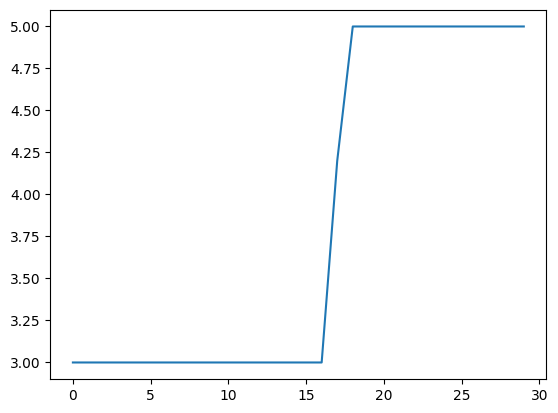

In [ ]:
plt.plot(og_labels[2, :, 0])
plt.show()

### Evaluate

In [ ]:
# Settings for window-based prediction
WINDOW_SIZE = 5

# Normalize labels for better optimization
D_max_normalization = image_props['D_max_norm']
all_labels = og_labels / np.array([D_max_normalization, D_max_normalization, 1])

# Reshape labels into frames
all_labels = all_labels.reshape(N, nFrames//WINDOW_SIZE, -1, 3).mean(axis=2) # shape: (N, total_windows, 3)
print(all_labels.shape)
# Convert to tensors
all_videos = torch.Tensor(all_videos)
all_labels = torch.Tensor(all_labels)
all_displacements = torch.Tensor(all_displacements)

# Create dataset and dataloader objects
dataset = VideoMotionDataset(all_videos, all_displacements, all_labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

batch_loss = []
errors = []

# Get predictions for one sample to plot
plot_preds = []
with torch.no_grad():
    for idx, (videos, displacements, labels) in enumerate(dataloader):
        videos = videos.to(device)
        displacements = displacements.to(device)
        labels = labels.to(device)

        window_loss = []

        # Make predictions for each window
        for window_idx, frame in enumerate(range(0, nFrames, WINDOW_SIZE)):
            end = frame + WINDOW_SIZE if frame + WINDOW_SIZE <= nFrames else nFrames
            val_predictions = model(videos[:,frame:end], displacements[:,frame:end])
            
            window_label = labels[:, window_idx]
            l = model_props['loss_fn'](val_predictions, window_label)
            window_loss.append(l.item())

            angle_pred = 0.5 * torch.atan2(val_predictions[:,2], val_predictions[:,3])
            mae = (val_predictions[...,:-2] - window_label[...,:-1]).abs().mean(axis=0)

            angle_sim = torch.abs(torch.cos(angle_pred - window_label[:,-1])).mean().unsqueeze(-1)
            errors.append(torch.cat([
                    mae.cpu() * D_max_normalization,
                    angle_sim.cpu()
                ], dim=0))
            
            if idx == 0:
                plot_preds.append(val_predictions[0].cpu())

        batch_loss.append(np.mean(window_loss))

plot_preds = torch.stack(plot_preds, dim=0).numpy() * np.array([D_max_normalization, D_max_normalization, 1, 1])

print(f"Average loss across validation set: {np.mean(batch_loss)}")
print(f"MAE of diffusion coefficients and angle simularity across validation set: {np.mean(errors, axis=0)}")

(5000, 6, 3)
Average loss across validation set: 1.7826760451501933
MAE of diffusion coefficients and angle simularity across validation set: [1.438271  1.8582284 0.6954546]


In [ ]:
print(plot_preds.shape, og_labels.shape)

(4, 4) (2000, 100, 3)


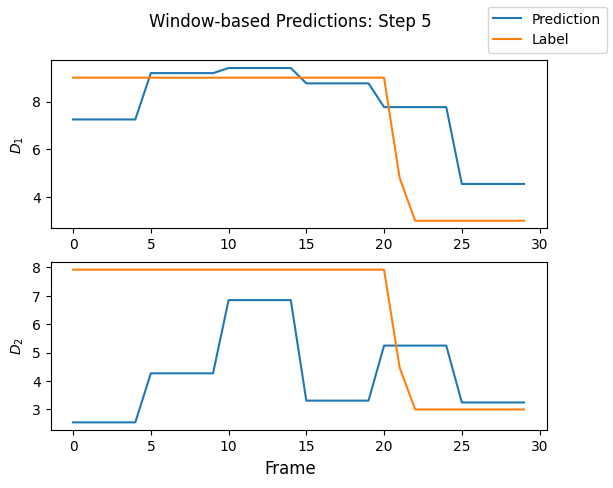

In [ ]:
# Plot predictions and labels across frames
fig, (ax1,ax2) = plt.subplots(2,1)

# Repeat labels to get back original shape of simulation
preds = np.tile(plot_preds[:, None, :], (1, WINDOW_SIZE, 1)).reshape(-1,4)
pred_D1 = preds[:,0]
pred_D2 = preds[:,1]
label_D1 = og_labels[0,:,0]
label_D2 = og_labels[0,:,1]

ax1.plot(pred_D1, label='Prediction')
ax1.plot(label_D1, label='Label')
ax2.plot(pred_D2)
ax2.plot(label_D2)
fig.suptitle(f'Window-based Predictions: Step {WINDOW_SIZE}')
ax1.set_ylabel(r'$D_{1}$')
ax2.set_ylabel(r'$D_{2}$')
fig.supxlabel('Frame')

fig.legend()
plt.show()

In [ ]:
# Settings for window-based prediction
WINDOW_SIZE = 10

# Normalize labels for better optimization
D_max_normalization = image_props['D_max_norm']
all_labels = og_labels / np.array([D_max_normalization, D_max_normalization, 1])

# Convert to tensors
all_videos = torch.Tensor(all_videos)
all_labels = torch.Tensor(all_labels)
all_displacements = torch.Tensor(all_displacements)

# Create dataset and dataloader objects
dataset = VideoMotionDataset(all_videos, all_displacements, all_labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

batch_loss = []
errors = []

# Get predictions for one sample to plot
plot_preds = []
with torch.no_grad():
    for idx, (videos, displacements, labels) in enumerate(dataloader):
        videos = videos.to(device)
        displacements = displacements.to(device)
        labels = labels.to(device)

        window_loss = []

        # Make predictions for each window
        for frame in range(nFrames-WINDOW_SIZE+1):
            end = frame + WINDOW_SIZE if frame + WINDOW_SIZE <= nFrames else nFrames
            val_predictions = model(videos[:,frame:end], displacements[:,frame:end])
            
            window_label = labels[:, frame:end].mean(dim=1)
            l = model_props['loss_fn'](val_predictions, window_label)
            window_loss.append(l.item())

            angle_pred = 0.5 * torch.atan2(val_predictions[:,2], val_predictions[:,3])
            if model_props['loss_fn'] is mse_loss or mse_loss_coeff:
                mae = (val_predictions[:,:-2] - window_label[:,:-1]).abs().mean(axis=0)
            else:
                mae = (torch.exp(val_predictions[:,:-2]) - window_label[:,:-1]).abs().mean(axis=0)

            angle_sim = torch.abs(torch.cos(angle_pred - window_label[:,-1])).mean().unsqueeze(-1)
            errors.append(torch.cat([
                    mae.cpu() * D_max_normalization,
                    angle_sim.cpu()
                ], dim=0))
            
            if idx == 0:
                plot_preds.append(val_predictions[0].cpu())

        batch_loss.append(np.mean(window_loss))

plot_preds = torch.stack(plot_preds, dim=0).numpy() * np.array([D_max_normalization, D_max_normalization, 1, 1])

print(f"Average loss across validation set: {np.mean(batch_loss)}")
print(f"MAE of diffusion coefficients and angle simularity across validation set: {np.mean(errors, axis=0)}")  

Average loss across validation set: 1.6935660701117077
MAE of diffusion coefficients and angle simularity across validation set: [1.1204542  1.2968795  0.70335656]


In [ ]:
print(plot_preds.shape, og_labels.shape)

(21, 4) (5000, 30, 3)


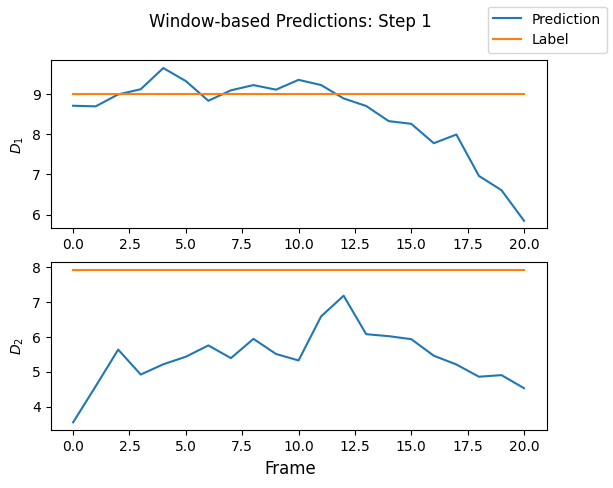

In [ ]:
# Plot predictions and labels across frames
fig, (ax1,ax2) = plt.subplots(2,1)

# Repeat labels to get back original shape of simulation
pred_D1 = plot_preds[:,0]
pred_D2 = plot_preds[:,1]
label_D1 = all_labels[0,:plot_preds.shape[0],0] * D_max_normalization
label_D2 = all_labels[0,:plot_preds.shape[0],1] * D_max_normalization

ax1.plot(pred_D1, label='Prediction')
ax1.plot(label_D1, label='Label')
ax2.plot(pred_D2)
ax2.plot(label_D2)
fig.suptitle('Window-based Predictions: Step 1')
ax1.set_ylabel(r'$D_{1}$')
ax2.set_ylabel(r'$D_{2}$')
fig.supxlabel('Frame')

fig.legend()
plt.show()

## Point-based Prediction

In [9]:
# Define model parameters
model_props= {
    "lr": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "hidden_dim": 128,
    "num_layers": 6,
    "dropout": 0.01,
    "batch_size": 16,
    "loss_fn": mse_loss,
    "weight_decay": 0.01,
    "use_pos_embed": False,
    "use_segment_embed": True,
    "use_rotary": True
}

if model_props['loss_fn'] is mse_loss_coeff:
    output_size = 2
else: 
    output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MultiStateModel(model_props['embed_dim'], model_props['num_heads'], model_props['hidden_dim'], 
            model_props['num_layers'], model_props['dropout'], output_dim=output_size, use_pos_embed=model_props['use_pos_embed'],
            use_segment_embed=model_props['use_segment_embed'], use_rotary=model_props["use_rotary"])
print(f"Total params of {model.__class__.__name__}: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Using device: cuda
Total params of MultiStateModel: 925284


In [10]:
# Load pretrained model
model_path = '../results_final/multi_state_binding_250000_20_64_0.0001_0.05.pt'
checkpoint = torch.load(model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
disp_stats = checkpoint['norm_stats']
model.to(device)
model.eval()

MultiStateModel(
  (image_encoder): DeepResNetEmbedding(
    (initial_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (res_block1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res_block2): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3

In [4]:
# Normalize labels for better optimization
D_max_normalization = image_props['D_max_norm']
all_labels = og_labels / np.array([D_max_normalization, D_max_normalization, 1])

# Convert to tensors
all_videos = torch.Tensor(all_videos)
all_labels = torch.Tensor(all_labels)
all_displacements = normalize_displacements(og_displacements, disp_stats)
all_displacements = torch.Tensor(all_displacements)

# Create dataset and dataloader objects
dataset = VideoMotionDataset(all_videos, all_displacements, all_labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

batch_loss = []
errors = []
mse_sims = []

# Get predictions for one sample to plot
plot_preds = []
plot_labels = []
change_errors = []
batchs = 0

with torch.no_grad():
    for idx, (videos, displacements, labels) in enumerate(dataloader):
        videos = videos.to(device)
        displacements = displacements.to(device)
        labels = labels.to(device)

        val_predictions = model(videos, displacements)
        val_loss = model_props['loss_fn'](val_predictions, labels)
        batch_loss.append(val_loss.item()) # batch loss

        #angle_pred = 0.5 * torch.atan2(val_predictions[...,2], val_predictions[...,3])
        mae = (val_predictions[...,:2] - labels[...,:-1]).abs().mean(dim=((0,1) if labels.dim()==3 else 0))

        sims = mse_similarity(val_predictions, labels)

        #angle_sim = torch.abs(torch.cos(angle_pred - labels[...,-1])).mean().unsqueeze(-1)
        # errors.append(torch.cat([
        #         mae.cpu() * D_max_normalization,
        #         angle_sim.cpu()
        #     ], dim=0))
        errors.append(mae.cpu() * D_max_normalization)
        mse_sims.append(sims.cpu())
        
        change_errors.append(val_predictions.shape[0] * compute_changepoint_error(val_predictions.cpu().numpy(), labels.cpu().numpy()))
        batchs += val_predictions.shape[0]
        
        plot_preds.extend(p.cpu() for p in val_predictions)
        plot_labels.extend(l.cpu() for l in labels)

print(f"Average loss across validation set: {np.mean(batch_loss)}")
print(f"MAE of diffusion coefficients and angle simularity across validation set: {np.mean(errors, axis=0)}")
print(f"Average L2-based similarity of diffusion tensors across validation set: {np.mean(mse_sims)}")
print(f"Average changepoint error across validation set: {np.sum(change_errors) / batchs}")

Average loss across validation set: 0.008720536103259914
MAE of diffusion coefficients and angle simularity across validation set: [0.3950272  0.39484343]
Average L2-based similarity of diffusion tensors across validation set: 0.9834120273590088
Average changepoint error across validation set: 5.1214


In [ ]:
from ipywidgets import interact, IntSlider

@interact(i=IntSlider(value=0, min=0, max=len(plot_preds), step=1))
def plot_point_based(i):
    # Plot predictions and labels across frames
    fig, (ax1,ax2) = plt.subplots(2,1)

    pred_D1 = plot_preds[i][:,0] * D_max_normalization
    pred_D2 = plot_preds[i][:,1] * D_max_normalization
    label_D1 = plot_labels[i][:,0] * D_max_normalization
    label_D2 = plot_labels[i][:,1] * D_max_normalization

    ax1.plot(pred_D1, label='Prediction')
    ax1.plot(label_D1, label='Label')
    ax2.plot(pred_D2)
    ax2.plot(label_D2)
    fig.suptitle('Point-based Prediction')
    ax1.set_ylabel(r'$D_{1}$ ($\frac{\mu m^2}{s}$)')
    ax2.set_ylabel(r'$D_{2}$ ($\frac{\mu m^2}{s}$)')
    fig.supxlabel('Frame')

    fig.legend()
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=5000), Output()), _dom_classes=('widget-interact…

In [ ]:
p = np.array(plot_preds)
l = np.array(plot_labels)

changepoints_pred = get_changepoints(p[..., :2])
changepoints_labels = get_changepoints(l[...,:-1])

errors = np.abs(changepoints_pred - changepoints_labels)

vals, cnts = np.unique(errors, return_counts=True)

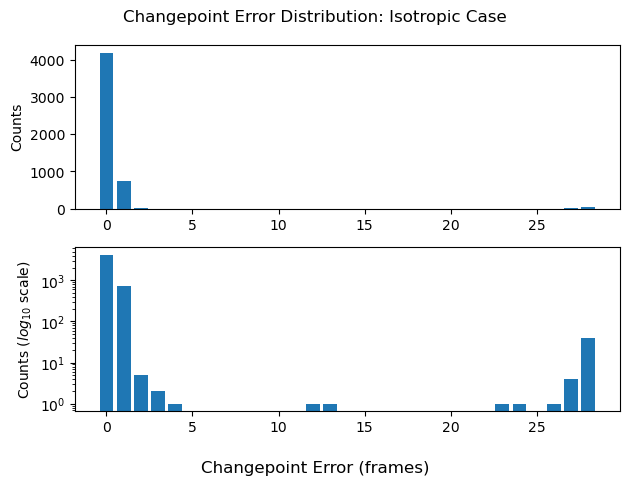

In [19]:
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.bar(vals, cnts)
ax1.set_ylabel('Counts')

ax2.bar(vals, cnts)
ax2.set_yscale('log')
ax2.set_ylabel(r'Counts ($log_{10}$ scale)')

fig.supxlabel('Changepoint Error (frames)')
fig.suptitle('Changepoint Error Distribution: Isotropic Case')
fig.tight_layout()
plt.show()